# Коллаборативная фильтрация

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
from implicit.evaluation import train_test_split


In [2]:
from metrics import hit_rate_at_k_mean_v2, ap_k,map_k_mean, \
NDCG_mean, precision_at_k, recall_at_k, reciprocal_rank_at_k, reciprocal_rank_mean, hit_rate_at_k_mean_v2, \
hit_rate_at_k, NDCG

# 1. Матричная факторизация

Раскладываем user-item матрицу на 2: матрицу латентных факторов юзеров и матрицу латентных факторов товаров

- латентый фактор = эмбеддинг (embedding)    

![mf.png](attachment:mf.png)

---

## Alternating Least Squares (ALS)

![als_formula.png](attachment:als_formula.png)

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Алгоритм**  
ALS - лишь способ оптимизации (поиска коэффициентов в эмбеддингах):  

1. Фиксируем эмбеддинги юзеров $x_u^T$ --> легко посчитать производную по эмбеддингам товаров $y_i$
2. Обновляем эмбеддинги товаров (делаем шаг по антиградиенту = градиентный спуск)
3. Фиксируем эмбеддинги товаров $y_i$ --> легко посчитать производную по эмбеддингам юзеров $x_u^T$
4. Обновляем эмбеддинги юзеров (делаем шаг по антиградиенту = градиентный спуск)
5. Повторяем, пока процедура не сойдется

**Плюсы**
- Очень быстрый
- В продакшене можно зафиксировать на весь день эмбеддинги товаров (товары за день не меняются), 
    и в реал-тайм обновлять эмбеддинги юзеров при покупке
- Есть решуляризация $\lambda_x$, $\lambda_y$
- Есть веса ошибок $с_{u_i}$ - элементы матрицы user-item
- Библиотека implicit под капотом использует Cyton - очень быстро работает
- Predict для *всех* юзеров можно сделать прост оперемножением 2-ух матриц - очень быстро
- Можно применять различные **взвешивания** матрицы: TF-IDF, BM25, ... . Это сильно улучшает качество

### 1. Базовое применение

pip install scipy==1.1.0

pip install implicit==0.6.2

In [3]:
import implicit
implicit.__version__

'0.6.2'

pip install ipywidgets

In [4]:
data = pd.read_csv('retail_train.csv')

test_size_weeks = 3
data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]
data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
len(data['user_id'].unique())

2499

In [6]:
users, items, interactions = data.user_id.nunique(), data.item_id.nunique(), data.shape[0]

print('# users: ', users)
print('# items: ', items)
print('# interactions: ', interactions)

# users:  2499
# items:  89051
# interactions:  2396804


In [7]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [8]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [9]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
popularity.head(2)

,item_id,n_sold
0,25671,6
1,26081,1


In [10]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
top_2500 = popularity.sort_values('n_sold', ascending=False).head(2500).item_id.tolist()
top_1000 = popularity.sort_values('n_sold', ascending=False).head(1000).item_id.tolist()

In [11]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.shape

(2499, 5001)

In [12]:
user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [14]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4, random_state=14)
model.fit(csr_matrix(user_item_matrix).tocsr(),  # На вход item-user matrix
          show_progress=True) #В ФИТЕ НЕ ТРАНСПОНИРУЕМ ОНО САМО ВНУТРИ СТРАНСПОНИРУЕТСЯ!!!!!

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 36.3 s
Wall time: 6.3 s


In [15]:
recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=itemid_to_id[999999], 
                        recalculate_user=False)

In [16]:
recs, [id_to_itemid[r] for r in recs[0]]

((array([4016, 3688, 4157, 3230, 3062]),
  array([1.112253 , 1.0504106, 1.0306642, 1.0292422, 1.0209731],
        dtype=float32)),
 [1133018, 1106523, 5569230, 1068719, 1053690])

In [17]:
%%time
user = [userid_to_id[user] for user in result['user_id']]
recs = model.recommend(userid=user, user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=itemid_to_id[999999], 
                                    recalculate_user=False)[0]

CPU times: total: 438 ms
Wall time: 232 ms


In [18]:
def id_item_to_real_id_item(recs, k):
    recsals = np.array([],dtype='i')
    for row in recs:
        a = [id_to_itemid[el] for el in row]
        recsals = np.append(recsals,a)
    recsals = recsals.reshape(-1,k)    
    return recsals

In [19]:
result['als']=id_item_to_real_id_item(recs, 5).tolist()

In [20]:
def metrics(recomended, actual, result, k):
    metrics = {}
    metrics[f'precision_at_{k}'] = result.apply(lambda row: precision_at_k(row[recomended], row[actual], k=k), axis=1).mean()
    metrics[f'recall_at_{k}'] = result.apply(lambda row: recall_at_k(row[recomended], row[actual], k=k), axis=1).mean()
    metrics[f'ap_{k}'] = result.apply(lambda row: ap_k(row[recomended], row[actual], k=k), axis=1).mean()
    metrics[f'ndsg_{k}'] = result.apply(lambda row: NDCG(row[recomended], row[actual], k=5), axis=1).mean()
    metrics[f'reciprocal_rank_at_{k}'] = result.apply(lambda row: reciprocal_rank_at_k(row[recomended], row[actual], k=k), axis=1).mean()
    return metrics

In [21]:
als_100_it = metrics('als', 'actual', result, 5)
als_100_it

{'precision_at_5': 0.202154750244858,
 'recall_at_5': 0.029159392501736405,
 'ap_5': 0.13113777342474697,
 'ndsg_5': 0.09476085396720425,
 'reciprocal_rank_at_5': 0.3766160626836435}

# 10 Итерааций

In [22]:
%%time

model = AlternatingLeastSquares(factors=10, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4, random_state=14)
model.fit(csr_matrix(user_item_matrix).tocsr(),  # На вход item-user matrix
          show_progress=True) #В ФИТЕ НЕ ТРАНСПОНИРУЕМ ОНО САМО ВНУТРИ СТРАНСПОНИРУЕТСЯ!!!!!

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 15.2 s
Wall time: 3.47 s


In [23]:
%%time
user = [userid_to_id[user] for user in result['user_id']]
recs = model.recommend(userid=user, user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=itemid_to_id[999999], 
                                    recalculate_user=False)[0]

CPU times: total: 547 ms
Wall time: 249 ms


In [24]:
result['als_10']=id_item_to_real_id_item(recs, 5).tolist()
als_10_it = metrics('als_10', 'actual', result, 5)
als_10_it

{'precision_at_5': 0.19637610186092067,
 'recall_at_5': 0.02446814584119271,
 'ap_5': 0.13813091740124062,
 'ndsg_5': 0.08688285104340572,
 'reciprocal_rank_at_5': 0.40963108063989556}

# 50 Итераций ALS

In [25]:
%%time

model = AlternatingLeastSquares(factors=50, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4, random_state=14)
model.fit(csr_matrix(user_item_matrix).tocsr(),  # На вход item-user matrix
          show_progress=True) #В ФИТЕ НЕ ТРАНСПОНИРУЕМ ОНО САМО ВНУТРИ СТРАНСПОНИРУЕТСЯ!!!!!

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 33 s
Wall time: 6.21 s


In [26]:
%%time
user = [userid_to_id[user] for user in result['user_id']]
recs = model.recommend(userid=user, user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=itemid_to_id[999999], 
                                    recalculate_user=False)[0]

CPU times: total: 562 ms
Wall time: 261 ms


In [27]:
result['als_50']=id_item_to_real_id_item(recs, 5).tolist()
als_50_it = metrics('als_50', 'actual', result, 5)
als_50_it

{'precision_at_5': 0.2167482859941234,
 'recall_at_5': 0.029081011043578475,
 'ap_5': 0.1446718903036239,
 'ndsg_5': 0.09823929253707488,
 'reciprocal_rank_at_5': 0.40264446620959843}

# Эмбединги

In [28]:
model.item_factors.shape

(5001, 50)

In [29]:
model.user_factors.shape

(2499, 50)

In [30]:
def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [31]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

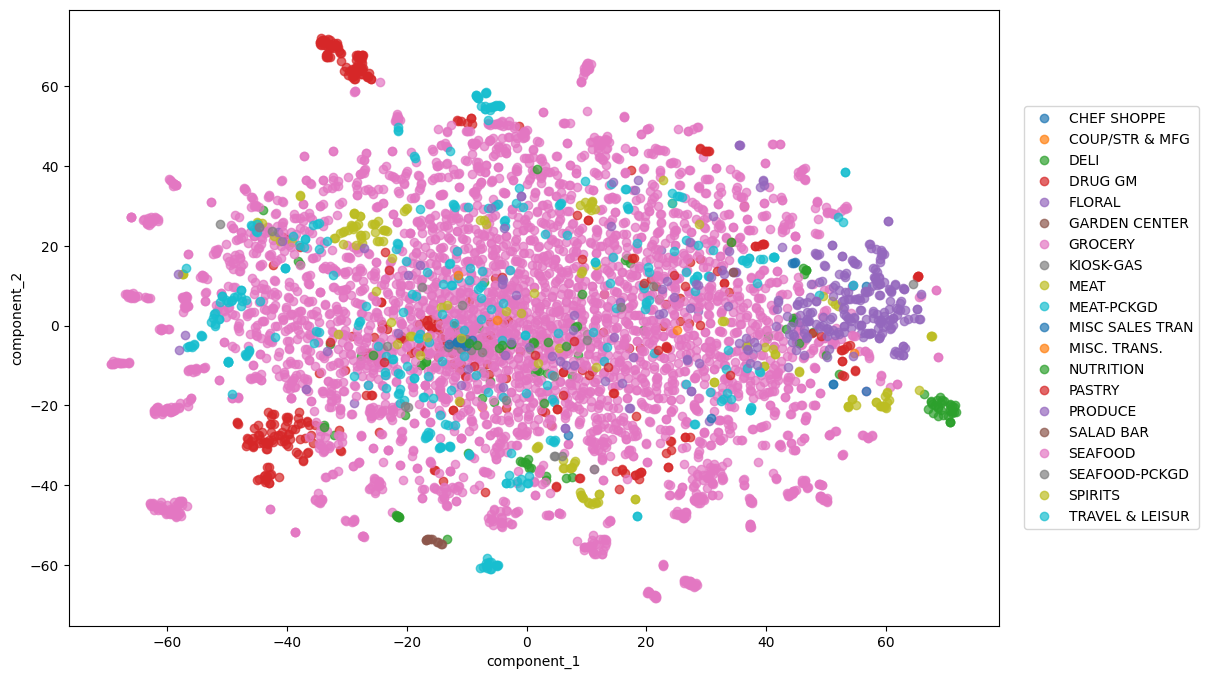

CPU times: total: 2min 17s
Wall time: 35 s


In [32]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

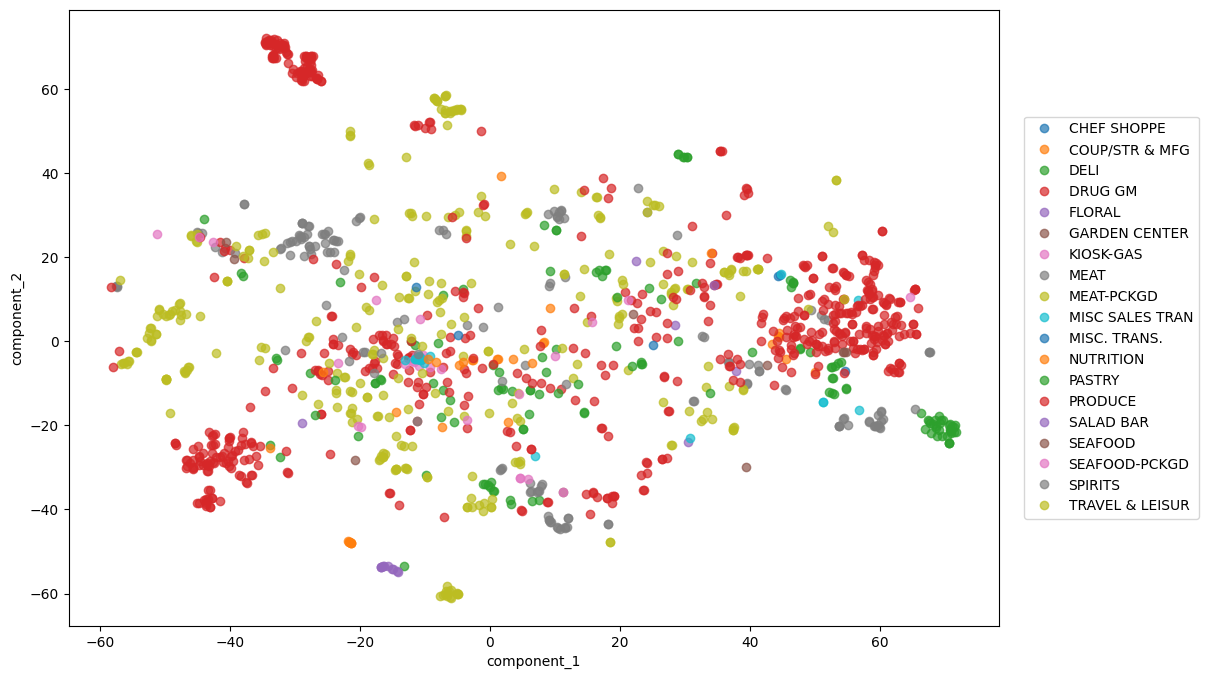

In [33]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

In [34]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,-10.814261,-3.859832,MISC SALES TRAN
1,-7.480109,-6.654963,KIOSK-GAS


In [60]:
%%time
recommendations = model.recommend_all(N=5,
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=itemid_to_id[999999],
                                      recalculate_user=True)

CPU times: total: 1.28 s
Wall time: 646 ms


In [63]:
len(recommendations.tolist())

2499

In [92]:
recs_simp = np.array([],dtype='i')
for row in recommendations:
    a = [id_to_itemid[el] for el in row]
    recs_simp = np.append(recs_simp,a)
recs_simp = recs_simp.reshape(-1,5)    

recom_sim = pd.DataFrame(userid_to_id.keys(), columns=['user_id'])
recom_sim['recs_simp'] = recs_simp.tolist()

,user_id,recs_simp
0,1,"[1100972, 1043128, 1004390, 824758, 1051211]"
1,2,"[981760, 995242, 1005493, 989824, 927291]"
2,3,"[844165, 935546, 1029743, 962229, 856060]"
3,4,"[1058930, 965766, 927291, 1082185, 951590]"
4,5,"[1082185, 849843, 981760, 837270, 995242]"
...,...,...
2494,2496,"[1004906, 1123842, 1022428, 833025, 973868]"
2495,2497,"[826385, 1056509, 963971, 1012922, 9707498]"
2496,2498,"[995242, 981760, 965766, 1033142, 1110843]"
2497,2499,"[1029743, 5569230, 840361, 1038217, 866140]"


In [103]:
result = result.merge(recom_sim, on='user_id')

In [105]:
recommendations_sim = metrics('recs_simp', 'actual', result, 5)
recommendations_sim

{'precision_at_5': 0.02585700293829579,
 'recall_at_5': 0.003893355162985555,
 'ap_5': 0.014061377734247468,
 'ndsg_5': 0.012343878961597323,
 'reciprocal_rank_at_5': 0.06439764936336925}

In [69]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

In [37]:
model.similar_items(1, N=5)

(array([   1, 4249,  478, 1355,  257]),
 array([1.       , 0.5916015, 0.5798877, 0.5700588, 0.5667649],
       dtype=float32))

In [38]:
model.similar_users(userid_to_id[10], N=5)

(array([   9,  790,  354, 1147, 1407]),
 array([0.9999999 , 0.6565355 , 0.6084428 , 0.5866291 , 0.55905896],
       dtype=float32))

# Взвешивание матрицы User Item

## TFIDF на 100 итерации и на 50

In [39]:
user_item_matrix_tf = tfidf_weight(user_item_matrix.T).T

In [40]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix_tf).tocsr(),  
          show_progress=True)

user = [userid_to_id[user] for user in result['user_id']]
recs = model.recommend(userid=user, user_items=csr_matrix(user_item_matrix_tf).tocsr(),   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=itemid_to_id[999999], 
                                    recalculate_user=False)[0]


result['als_100_it_tfidf']=id_item_to_real_id_item(recs, 5).tolist()
als_100_it_tfidf = metrics('als_100_it_tfidf', 'actual', result, 5)
als_100_it_tfidf

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 48.8 s
Wall time: 9.91 s


{'precision_at_5': 0.1712047012732615,
 'recall_at_5': 0.02393780425073511,
 'ap_5': 0.10636467515507673,
 'ndsg_5': 0.08080984425264391,
 'reciprocal_rank_at_5': 0.32040483186418545}

In [41]:
%%time

model = AlternatingLeastSquares(factors=50, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix_tf).tocsr(),  
          show_progress=True)

user = [userid_to_id[user] for user in result['user_id']]
recs = model.recommend(userid=user, user_items=csr_matrix(user_item_matrix_tf).tocsr(),   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=itemid_to_id[999999], 
                                    recalculate_user=False)[0]


result['als_50_it_tfidf']=id_item_to_real_id_item(recs, 5).tolist()
als_50_it_tfidf = metrics('als_50_it_tfidf', 'actual', result, 5)
als_50_it_tfidf

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 44.1 s
Wall time: 9.79 s


{'precision_at_5': 0.17531831537708129,
 'recall_at_5': 0.023822415775892062,
 'ap_5': 0.11142997061704213,
 'ndsg_5': 0.07944478863372192,
 'reciprocal_rank_at_5': 0.33345576232451846}

## BM взвешивание User Item матрицы на 100 и 50 итераций

In [42]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
user_item_matrix_bm = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [44]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix_bm).tocsr(),  
          show_progress=True)

user = [userid_to_id[user] for user in result['user_id']]
recs = model.recommend(userid=user, user_items=csr_matrix(user_item_matrix_bm).tocsr(),   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=itemid_to_id[999999], 
                                    recalculate_user=False)[0]


result['als_100_it_bf']=id_item_to_real_id_item(recs, 5).tolist()
als_100_it_bf = metrics('als_100_it_bf', 'actual', result, 5)
als_100_it_bf

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 47.3 s
Wall time: 9.95 s


{'precision_at_5': 0.11332027424094024,
 'recall_at_5': 0.018415988705548475,
 'ap_5': 0.06439601697682011,
 'ndsg_5': 0.055465683731271795,
 'reciprocal_rank_at_5': 0.2132141691152465}

In [46]:
%%time

model = AlternatingLeastSquares(factors=50, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix_bm).tocsr(),  
          show_progress=True)

user = [userid_to_id[user] for user in result['user_id']]
recs = model.recommend(userid=user, user_items=csr_matrix(user_item_matrix_bm).tocsr(),   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=itemid_to_id[999999], 
                                    recalculate_user=False)[0]


result['als_50_it_bf']=id_item_to_real_id_item(recs, 5).tolist()
als_50_it_bf = metrics('als_100_it_bf', 'actual', result, 5)
als_50_it_bf

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 36.3 s
Wall time: 8.08 s


{'precision_at_5': 0.11332027424094024,
 'recall_at_5': 0.018415988705548475,
 'ap_5': 0.06439601697682011,
 'ndsg_5': 0.055465683731271795,
 'reciprocal_rank_at_5': 0.2132141691152465}

# Сводная таблица мерик

In [106]:
metrics_df = pd.DataFrame(als_100_it.values(), index=als_100_it.keys(), columns=['als_100_it'])
metrics_df.insert(loc=len(metrics_df.columns), column='als_50_it', value=als_50_it.values())
metrics_df.insert(loc=len(metrics_df.columns), column='als_10_it', value=als_10_it.values())
metrics_df.insert(loc=len(metrics_df.columns), column='als_100_it_tfidf', value=als_100_it_tfidf.values())
metrics_df.insert(loc=len(metrics_df.columns), column='als_50_it_tfidf', value=als_50_it_tfidf.values())
metrics_df.insert(loc=len(metrics_df.columns), column='als_100_it_bf', value=als_100_it_bf.values())
metrics_df.insert(loc=len(metrics_df.columns), column='als_50_it_bf', value=als_100_it_bf.values())
metrics_df.insert(loc=len(metrics_df.columns), column='similar', value=recommendations_sim.values())
metrics_df

,als_100_it,als_50_it,als_10_it,als_100_it_tfidf,als_50_it_tfidf,als_100_it_bf,als_50_it_bf,similar
precision_at_5,0.202155,0.216748,0.196376,0.171205,0.175318,0.113320,0.113320,0.025857
recall_at_5,0.029159,0.029081,0.024468,0.023938,0.023822,0.018416,0.018416,0.003893
ap_5,0.131138,0.144672,0.138131,0.106365,0.111430,0.064396,0.064396,0.014061
ndsg_5,0.094761,0.098239,0.086883,0.080810,0.079445,0.055466,0.055466,0.012344
reciprocal_rank_at_5,0.376616,0.402644,0.409631,0.320405,0.333456,0.213214,0.213214,0.064398


### Самой оптимальной оказалась система с 50 итерациями и без взвешивание. Взвешивание в целом уменьшает влияние популярных продуктов так как их покупает большее число людей и они встречаются реже в ситеме рекомендаций

# лямбда функция не работает хотя все тоже самое было подано без нее но ошибок не было однако у меня куда то теряк\ется один их пользователей в отличии от вебинара где их 2500 у меня их 2499

In [45]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=itemid_to_id[999999], 
                                    recalculate_user=False)[0]]
    return res

%%time
result['als'] = result['user_id'].apply(lambda x: get_recommendations(userid_to_id[x], model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

----